<a href="https://colab.research.google.com/github/canneltigrou/canneltigrou.github.io/blob/master/JupyterNotebooks/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import zipfile
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing import image


import numpy as np
import matplotlib.pyplot as plt


I set the seed to have always the same results


In [2]:
from numpy.random import seed
seed(42) 

from tensorflow import random
random.set_seed(42)

# prepare the data
Please upload the dataset into your current directory

In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tQIzrEapfBG7bjfusUW7LOcrOCVGmPmd' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tQIzrEapfBG7bjfusUW7LOcrOCVGmPmd" -O dataset.zip && rm -rf /tmp/cookies.txt

--2021-01-04 08:19:01--  https://docs.google.com/uc?export=download&confirm=3ywK&id=1tQIzrEapfBG7bjfusUW7LOcrOCVGmPmd
Resolving docs.google.com (docs.google.com)... 172.217.2.110, 2607:f8b0:4004:80a::200e
Connecting to docs.google.com (docs.google.com)|172.217.2.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-2c-docs.googleusercontent.com/docs/securesc/bp7fdphi05slg6a68kgmlgh7d4h5u65t/u1q1nh7iokb585i8haereasal5tpevrd/1609748325000/13115173566265240584/12714189590053564035Z/1tQIzrEapfBG7bjfusUW7LOcrOCVGmPmd?e=download [following]
--2021-01-04 08:19:01--  https://doc-0s-2c-docs.googleusercontent.com/docs/securesc/bp7fdphi05slg6a68kgmlgh7d4h5u65t/u1q1nh7iokb585i8haereasal5tpevrd/1609748325000/13115173566265240584/12714189590053564035Z/1tQIzrEapfBG7bjfusUW7LOcrOCVGmPmd?e=download
Resolving doc-0s-2c-docs.googleusercontent.com (doc-0s-2c-docs.googleusercontent.com)... 172.217.7.161, 2607:f8b0:4004:800::2001
Connecting to doc-0s-2

In [2]:
!unzip -qq dataset.zip -d data/

In the dataset, we have 8 different folders corresponding to 8 objects (classes).

- airplane
- car  
- cat  
- dog  
- flower  
- fruit  
- motorbike  
- person  

We would like to classify an image into one of these classes.

To do this, We will build a neural network.  
First we have to split the data, in order to have a train dataset and a test dataset.  
Our input (X) will be the image. The output Y the corresponding class


## upload the images and labels

In [5]:
from PIL import Image

idx_to_classes = ['airplane', 'car', 'cat', 'dog',
                  'flower', 'fruit', 'motorbike', 'person']

image_size = (150, 150)

def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                spec.append(np.asarray(Image.open(entry.path).resize(image_size)))
                # add associated label
                labels.append(idx)

    return np.array(spec), np.array(labels)

In [6]:
base_dir = 'data/natural_images'
X_data, Y_data = load_dataset(base_dir)


Let's see a little what the data looks like

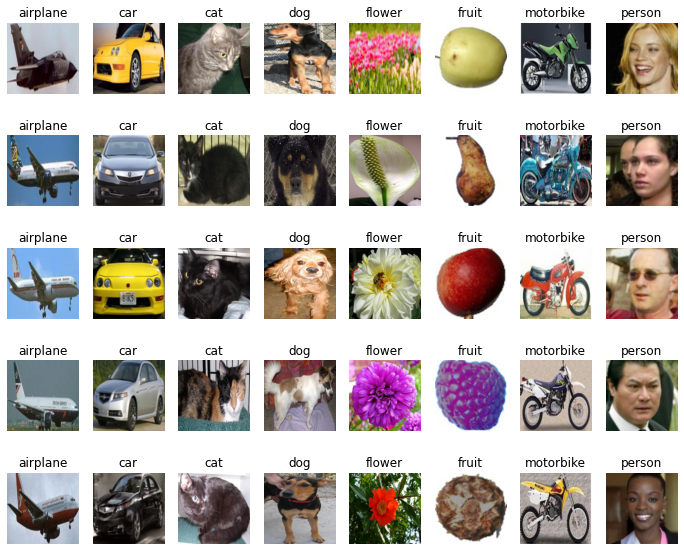

In [7]:
# we have 8 classes. Let's show 5 images of each classes. (-> 40 images)
plt.figure(figsize=(12,10))

for i in range(8):

    # chargement de l'image
    label = idx_to_classes[i]
    with os.scandir(os.path.join(base_dir, label)) as it:
      j = 0
      for entry in list(it)[0:5]:
        img = Image.open(entry.path).resize(image_size)
        plt.subplot(5,8,8*j + i + 1)
        plt.imshow(img)
        plt.title(label)
        j = j+1
        plt.axis('off')
   
              
plt.show()

## Split into train and test

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, train_size = 0.7) 

## preprocess the images.  
 we will normalize pixel values to be between 0 and 1.
 We already reshape as image_size dimension.

In [9]:
for img in X_train:
  img = img / 255.0
for img in X_test:
  img = img / 255.0


## preprocess the labels
we want to have make y as a one-hot encoding to correspond to the output of our cnn model

In [10]:
# one-hot encoding
nb_classes = 8
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# train a model



We know that CNN works well with images. I propose a simple model with some convolutions (with a 3*3 mask) followed by maxpooling.  
Then we flatten the results to give it to 3 hidden layers of respectively 100 - 100 - 50 neurons, then the output layer (8 neurons corresponding to the 8 classes)

## build the model

In [11]:
model = Sequential()

img_shape = X_test[0].shape
print(img_shape)

model.add(Conv2D(32, (3, 3), input_shape=img_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Dropout(0.3)) #to avoid overfitting
model.add(Activation('relu'))

# classification
model.add(Dense(8))
model.add(Activation('softmax')) #since we want a classification

# Compile
model.compile(loss='categorical_crossentropy', 
              optimizer='adagrad', 
              metrics=['accuracy'])

# Affichage des informations sur le réseau défini au-dessus
model.summary()

(150, 150, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34

## train the model on the training set

In [12]:
history = model.fit(X_train, Y_train, batch_size=32, epochs = 25, verbose = 1)

Epoch 1/25
83/83 [==============================] - 10s 25ms/step - loss: 4.3733 - accuracy: 0.3202
Epoch 2/25
83/83 [==============================] - 2s 23ms/step - loss: 1.0710 - accuracy: 0.6269
Epoch 3/25
83/83 [==============================] - 2s 22ms/step - loss: 0.7687 - accuracy: 0.7413
Epoch 4/25
83/83 [==============================] - 2s 23ms/step - loss: 0.6405 - accuracy: 0.7824
Epoch 5/25
83/83 [==============================] - 2s 23ms/step - loss: 0.5175 - accuracy: 0.8283
Epoch 6/25
83/83 [==============================] - 2s 23ms/step - loss: 0.3907 - accuracy: 0.8787
Epoch 7/25
83/83 [==============================] - 2s 23ms/step - loss: 0.3668 - accuracy: 0.8725
Epoch 8/25
83/83 [==============================] - 2s 23ms/step - loss: 0.3278 - accuracy: 0.8873
Epoch 9/25
83/83 [==============================] - 2s 23ms/step - loss: 0.2451 - accuracy: 0.9173
Epoch 10/25
83/83 [==============================] - 2s 23ms/step - loss: 0.2412 - accuracy: 0.9232
Epoch 11

Let's study the accuracy during the training



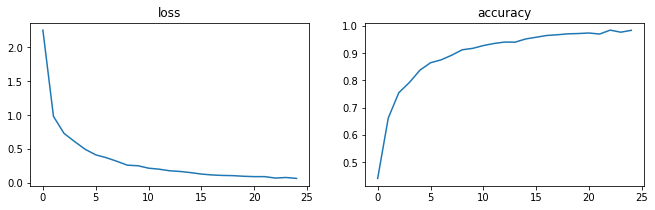

In [13]:
plt.figure(figsize=(11,3))

# loss plot on the training set
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# accuracy plot on the training set
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

We obtain an accuracy near 98% on  the training set

## study the results

36/36 [==============================] - 0s 10ms/step
Confusion matrix (rows: true classes; columns: predicted classes):

[[223   2   0  13   1   0   1   0]
 [  1 106   1   2   1   0   0   1]
 [  3   1  20  36   1   0   1   0]
 [  4   1   9 182   1   0   1   2]
 [  1   0   2   2  32   0   1   2]
 [  0   0   0   0   0 103   0   0]
 [  1   1   0   0   0   0 224   0]
 [  0   0   0   0   0   1   0 153]]

Classification accuracy for each class:

0: 0.9292
1: 0.9464
2: 0.3226
3: 0.9100
4: 0.8000
5: 1.0000
6: 0.9912
7: 0.9935


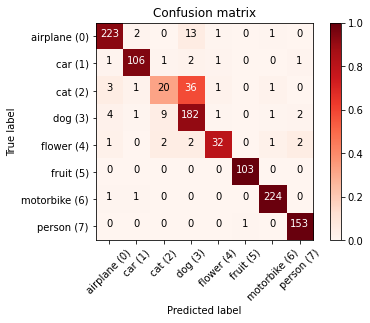

In [14]:
predictions = model.predict(X_test, verbose=1)

from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(8)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%d: %.4f" % (i,j))

    
percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(percent, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion matrix')
plt.grid(None)
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh =percent.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if percent[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

We can see that the network can still improve for cat recognition.  
In fact for lots of cat images, the network predicts a dog. However, we can see that we have less images of cats ! Maybe we can improve our network just training on more cat images.  
To do so, we can add new images, or make some image augmentations.

# Tansfert learning

In image classification, VGG19 has a good accuracy. We can do a transfer learning from the CNN VGG19 since it contains similar objects that we have to recognize.


## importation of the model

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

Let's see how the VGG19 model looks like

In [ ]:
VGG19().summary()

574717952/574710816 [==============================] - 5s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
model = VGG19(include_top=False, input_shape=(150, 150, 3))

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
from keras.models import Model

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(200, activation='relu')(flat1)
class2 = Dense(200, activation='relu')(class1)
dropout1 = Dropout(0.4)(class2)
output = Dense(8, activation='softmax')(dropout1)
# define new model
model = Model(inputs=model.inputs, outputs=output)

# define new model
model_VGG = Model(inputs=model.inputs, outputs=output)

In [ ]:
model_VGG.compile(loss='categorical_crossentropy', 
              optimizer='adagrad', 
              metrics=['accuracy'])

In [ ]:
history = model_VGG.fit(X_train, Y_train, batch_size=32, epochs = 25, verbose = 1)

Epoch 1/25
83/83 [==============================] - 21s 252ms/step - loss: 1.8120 - accuracy: 0.4629
Epoch 2/25
83/83 [==============================] - 20s 235ms/step - loss: 0.4644 - accuracy: 0.8364
Epoch 3/25
83/83 [==============================] - 20s 238ms/step - loss: 0.2175 - accuracy: 0.9269
Epoch 4/25
83/83 [==============================] - 20s 241ms/step - loss: 0.1344 - accuracy: 0.9570
Epoch 5/25
83/83 [==============================] - 20s 243ms/step - loss: 0.1023 - accuracy: 0.9619
Epoch 6/25
83/83 [==============================] - 20s 246ms/step - loss: 0.0545 - accuracy: 0.9812
Epoch 7/25
83/83 [==============================] - 21s 247ms/step - loss: 0.0315 - accuracy: 0.9894
Epoch 8/25
83/83 [==============================] - 21s 248ms/step - loss: 0.7221 - accuracy: 0.8504
Epoch 9/25
83/83 [==============================] - 21s 255ms/step - loss: 0.0762 - accuracy: 0.9721
Epoch 10/25
83/83 [==============================] - 21s 257ms/step - loss: 0.0377 - accura

Let's study the accuracy during the training

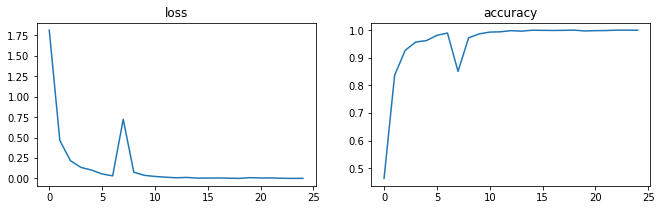

In [ ]:
plt.figure(figsize=(11,3))

# loss plot on the training set
plt.subplot(1,2,1)
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

# accuracy plot on the training set
plt.subplot(1,2,2)
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

## Results on test data

36/36 [==============================] - 3s 89ms/step
Confusion matrix (rows: true classes; columns: predicted classes):

[[240   0   0   0   0   0   0   0]
 [  0 112   0   0   0   0   0   0]
 [  0   0  54   8   0   0   0   0]
 [  1   0   5 194   0   0   0   0]
 [  0   0   0   0  40   0   0   0]
 [  0   0   0   0   0 103   0   0]
 [  0   1   0   0   0   0 225   0]
 [  0   0   0   0   0   0   0 154]]

Classification accuracy for each class:

0: 1.0000
1: 1.0000
2: 0.8710
3: 0.9700
4: 1.0000
5: 1.0000
6: 0.9956
7: 1.0000


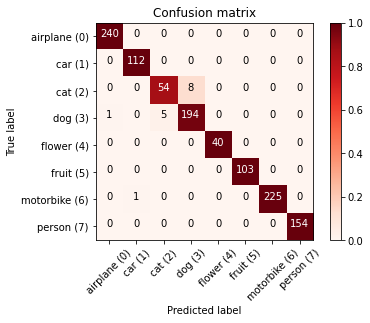

In [ ]:
predictions = model_VGG.predict(X_test, verbose=1)

from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, np.argmax(predictions, axis=1), labels=list(range(8)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.
                     sum(axis=1)):
    print("%d: %.4f" % (i,j))

percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(percent, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion matrix')
plt.grid(None)
plt.colorbar()
tick_marks = np.arange(len(idx_to_classes))
plt.grid(None)
classes_name = zip(idx_to_classes, list(range(len(idx_to_classes))))
classes_name = ['{} ({})'.format(*i) for i in classes_name]
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh =percent.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if percent[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()